In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

In [2]:
# load predicted values from the previous 6-fold cross-validation as df
bert_p_1 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_p_bert_ds6_fold1_results.csv')
bert_p_2 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_p_bert_ds5_fold2_results.csv')
bert_p_3 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_p_bert_ds4_fold3_results.csv')
bert_p_4 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_p_bert_ds3_fold4_results.csv')
bert_p_5 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_p_bert_ds4_fold5_results.csv')
bert_p_6 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune/hansen_p_bert_ds1_fold6_results.csv')
# concat data
bert = pd.concat((bert_p_1, bert_p_2, bert_p_3, bert_p_4, bert_p_5, bert_p_6), axis=0)

In [3]:
bert_p_1["index"] = bert_p_1["smiles"].str.find('c1ccnnc1')

In [4]:
bert_p_1.loc[lambda bert_p_1: bert_p_1["index"] == 0]

,Unnamed: 0,smiles,actual,predict,index
73,73,c1ccnnc1,17.4,7.676718,0


In [5]:
len(bert)

1183

In [6]:
# calculate the residual value for each molecule
bert['residual']= bert['predict']-bert['actual']

In [7]:
# calculate standardised deviation of the residuals (sdr) of the dataset
# equations used: sdr = sqrt((sum((residual)**2))/(n-2))
sdr = np.sqrt((bert['residual']**2).sum()/(len(bert)-2))
sdr

2.8449176675287586

In [8]:
# calculate how many sdr each molecule's predicted value is away from the exp value 
bert['std_residual'] = bert['residual']/sdr
bert['std_residual']

0      2.292499
1      0.080902
2      0.674409
3      0.095615
4      1.103716
         ...   
193    0.038713
194    0.644091
195   -0.202673
196   -0.715903
197    0.302405
Name: std_residual, Length: 1183, dtype: float64

In [9]:
# n is 2 or 3. Points 2 or 3 sdr away from the prediction line are likely to be outliers
n = 3
bert_outliers = bert.loc[abs(bert['std_residual']) > n]
bert_outliers

,Unnamed: 0,smiles,actual,predict,residual,std_residual
24,24,NCCO,15.5,6.473965,-9.026035,-3.172688
25,25,Cc1ccon1,14.8,4.637506,-10.162494,-3.572158
73,73,c1ccnnc1,17.4,7.676718,-9.723282,-3.417773
134,134,S=C=S,0.0,11.609549,11.609549,4.080803
177,177,ClC(Cl)(Cl)Cl,0.0,8.893689,8.893689,3.126167
123,123,O=[S]=O,8.4,16.964512,8.564512,3.010460
48,48,Sc1cc(Cl)c(Cl)cc1Cl,4.5,13.439131,8.939131,3.142140
156,156,CN=C=S,16.2,4.759526,-11.440474,-4.021373
4,4,ClC(Cl)(Cl)C=C,15.5,4.511293,-10.988707,-3.862575
38,38,[Ca++].NC#N,27.6,13.453582,-14.146418,-4.972523


In [10]:
# Set the default text font size
plt.rc('font', size=22)

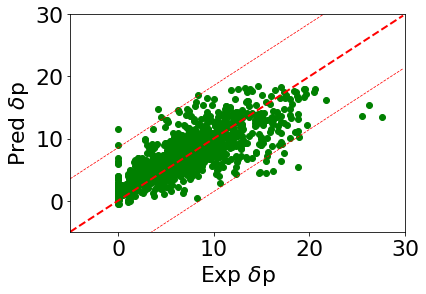

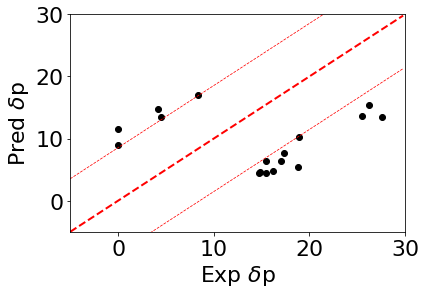

In [11]:
plt.figure(2)

# plot of exp vs pred of all molecules in the dataset
# The thick red lines indicate ideal agreement between the predicted and experimental values. 
# The dashed red lines indicate 3 srd (n=3) away from the ideal agreement. 
ln = np.arange(-5, 30, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert['actual'], y=bert['predict'], color='green')
plt.xlabel('Exp $\delta$p')
plt.ylabel('Pred $\delta$p')
plt.xlim([-5,30])
plt.ylim([-5,30])
plt.show()

# Plot of the outliers identified 
# check visually to confirm they are on or beyond 3 srd
ln = np.arange(-5, 30, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert_outliers['actual'], y=bert_outliers['predict'], color='black')
plt.xlabel('Exp $\delta$p')
plt.ylabel('Pred $\delta$p')
plt.xlim([-5,30])
plt.ylim([-5,30])
plt.show()

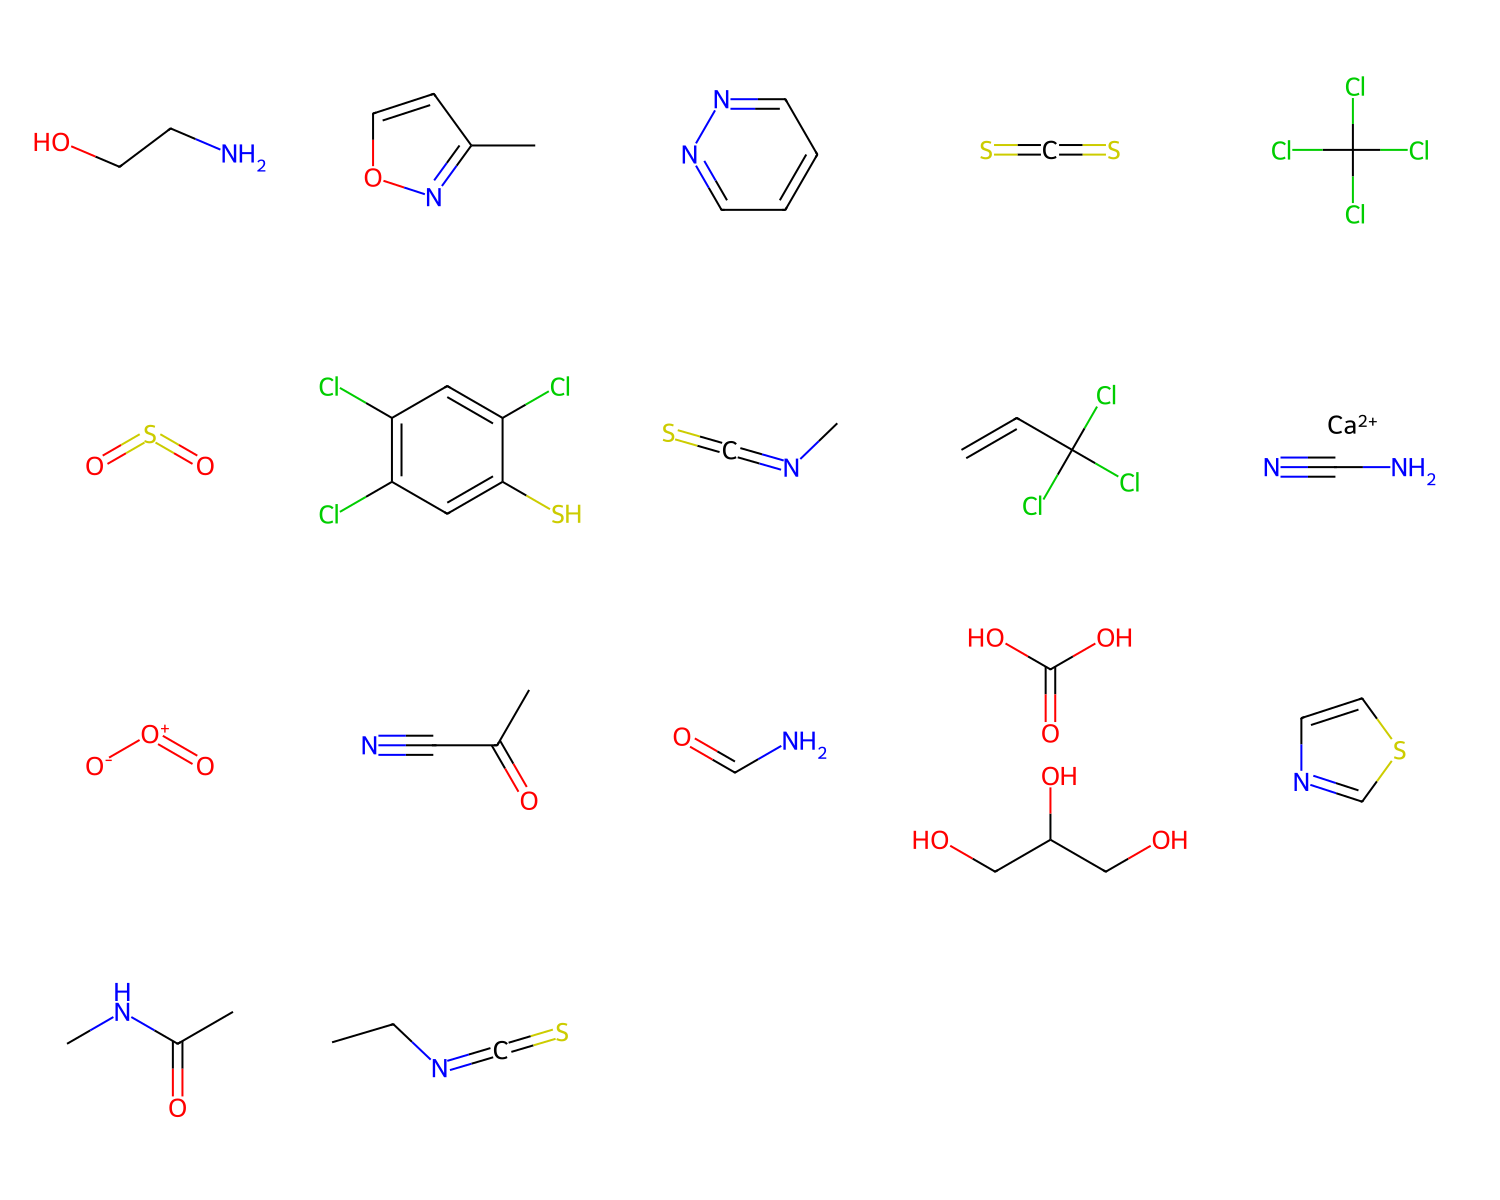

In [12]:
# draw n=3 outlier structure
outliners = [Chem.MolFromSmiles(x) for x in bert_outliers['smiles']]
Draw.MolsToGridImage(outliners, subImgSize=(300,300), molsPerRow=5, maxMols=50)

In [13]:
bert_outliers.to_csv('bert_p_outliers3.csv')

In [14]:
# n is 2 or 3. Points 2 or 3 sdr away from the prediction line are likely to be outliers
n = 2
bert_outliers2 = bert.loc[abs(bert['std_residual']) > n]
bert_outliers2

,Unnamed: 0,smiles,actual,predict,residual,std_residual
0,0,SC#N,8.9,15.421972,6.521972,2.292499
13,13,CC1COC(=O)O1,18.0,10.137788,-7.862212,-2.763599
24,24,NCCO,15.5,6.473965,-9.026035,-3.172688
25,25,Cc1ccon1,14.8,4.637506,-10.162494,-3.572158
32,32,O=C1OCC=C1,19.8,12.172516,-7.627484,-2.681091
...,...,...,...,...,...,...
112,112,CC(Cl)=C(Cl)Cl,15.7,7.803375,-7.896625,-2.775695
115,115,OCCOCCOCCO,12.5,6.733089,-5.766911,-2.027092
127,127,O=Cc1occc1,14.9,8.998567,-5.901433,-2.074377
153,153,CCCCCCCCCC(C)(O)Oc1ccccc1,10.2,4.259024,-5.940976,-2.088277


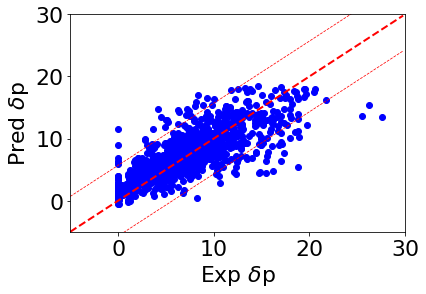

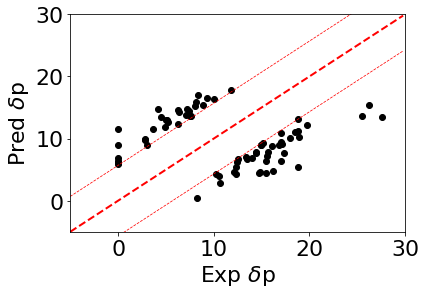

In [16]:
plt.figure(2)

# plot of exp vs pred of all molecules in the dataset
# The thick red lines indicate ideal agreement between the predicted and experimental values. 
# The dashed red lines indicate 2 srd (n=2) away from the ideal agreement. 
ln = np.arange(-5, 30, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert['actual'], y=bert['predict'], color='blue')
plt.xlabel('Exp $\delta$p')
plt.ylabel('Pred $\delta$p')
plt.xlim([-5,30])
plt.ylim([-5,30])
plt.show()

# Plot of the outliers identified 
# check visually to confirm they are on or beyond 2 srd
ln = np.arange(-5, 30, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert_outliers2['actual'], y=bert_outliers2['predict'], color='black')
plt.xlabel('Exp $\delta$p')
plt.ylabel('Pred $\delta$p')
plt.xlim([-5,30])
plt.ylim([-5,30])
plt.show()

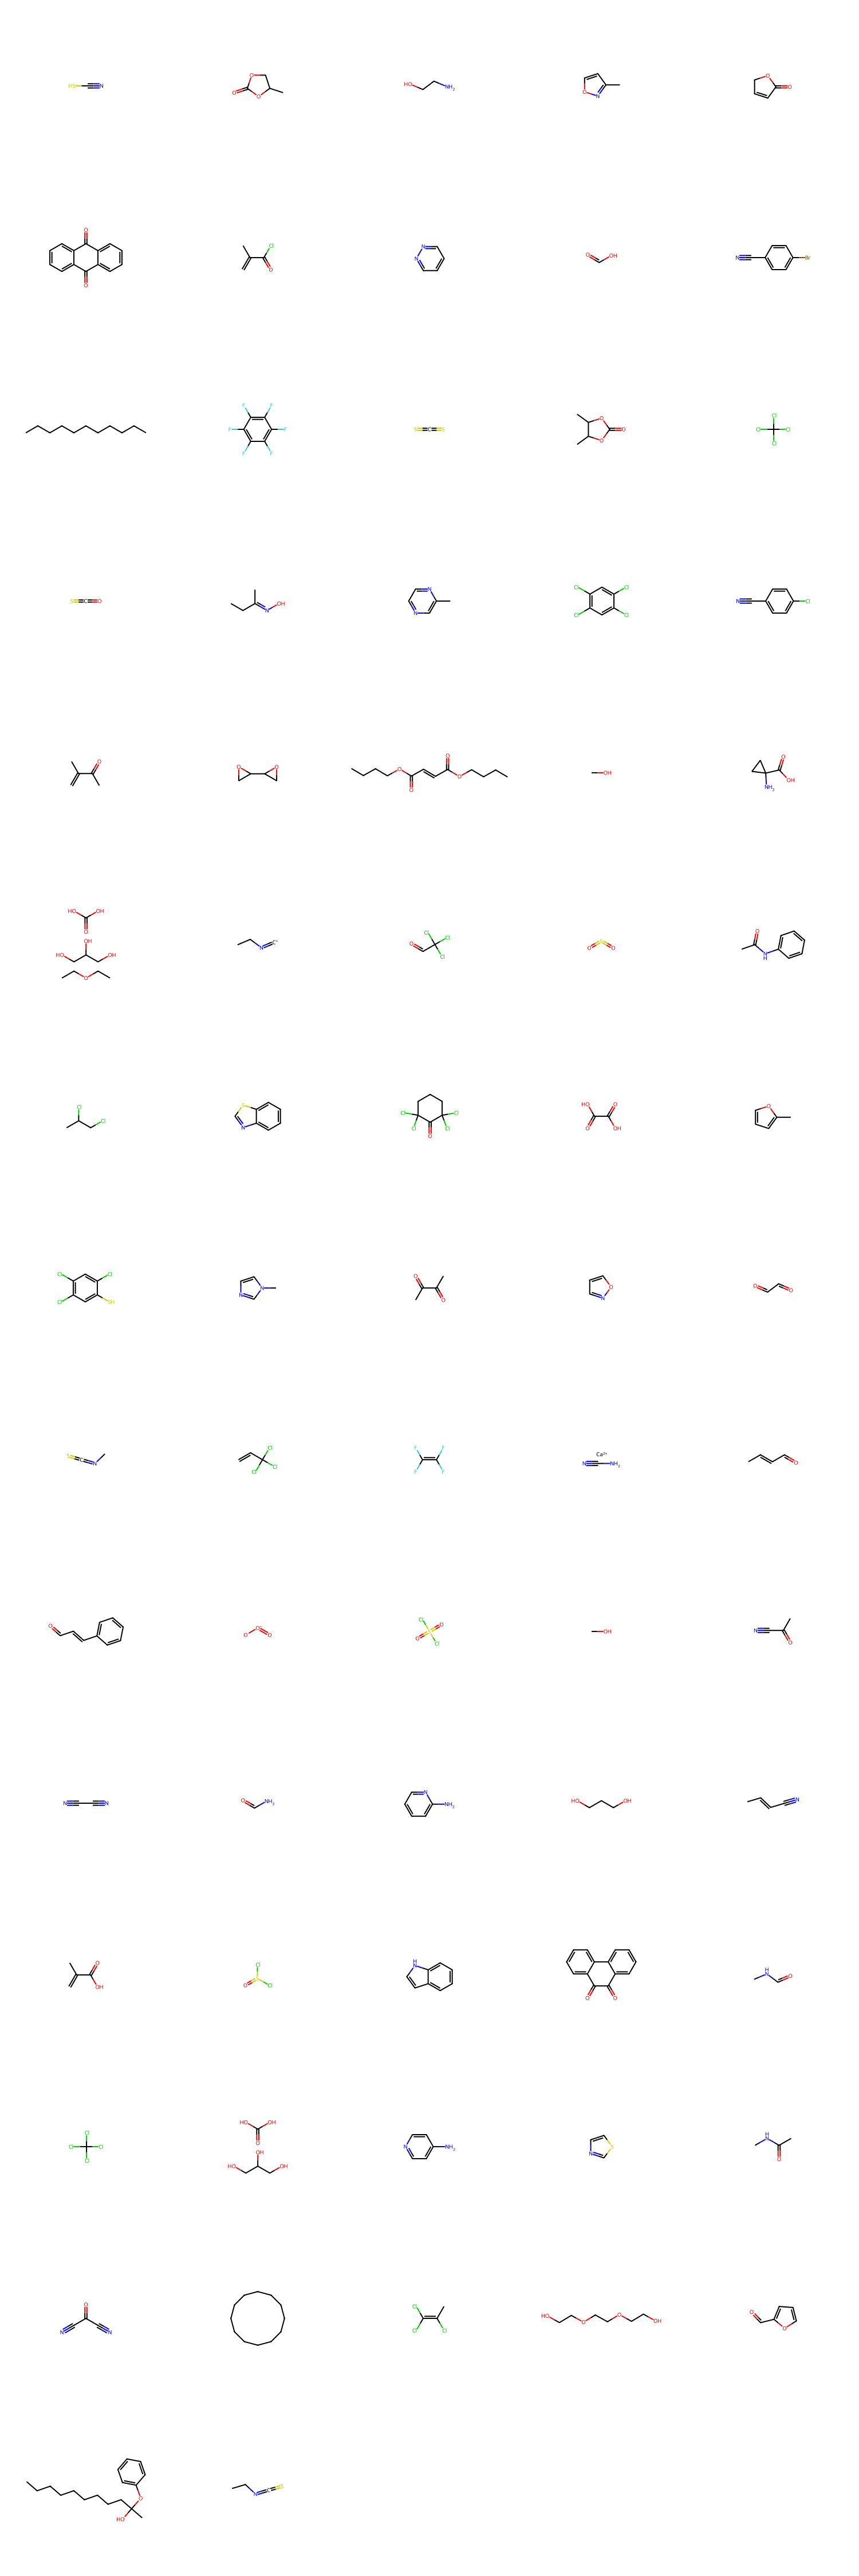

In [14]:
# draw n=2 outlier structure
outliners2 = [Chem.MolFromSmiles(x) for x in bert_outliers2['smiles']]
Draw.MolsToGridImage(outliners2, subImgSize=(300,300), molsPerRow=5, maxMols=100)

In [15]:
# save outliers (n=2) info to a csv file
bert_outliers2.to_csv('bert_p_outliers2.csv')

In [16]:
from rdkit.Chem import Descriptors
gpHSP_data = pd.read_csv('/Users/jiayun/Documents/work/mol2vec/hansen_1k_smiles_shorter.csv')
mol_smiles = gpHSP_data['SMILES']

# calculate molecular weight of the full dataset
molwt = [(Descriptors.ExactMolWt(Chem.MolFromSmiles(x))) for x in gpHSP_data['SMILES']]
np_molwt = np.asarray(molwt)

# calculate molecular weight of outliers
molwt_outliers2 = [(Descriptors.ExactMolWt(Chem.MolFromSmiles(x))) for x in bert_outliers2['smiles']]
np_molwt_outliers2 = np.asarray(molwt_outliers2)

# Compare average molecular weight for full data and outliers
print(np.average(np_molwt))
print(np.average(np_molwt_outliers2))

131.2953603288794
110.55933893711486


In [ ]:
# Set the default text font size
plt.rc('font', size=16)

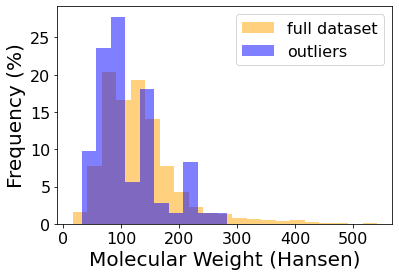

In [17]:
# plot molecular weight distribution for the full dataset and the outliers
bin_width = 25
df = pd.DataFrame(np_molwt, columns = ["full dataset"])
df2 = pd.DataFrame(np_molwt_outliers2, columns = ["outliers"])

ax = df.plot.hist(bins=(np.arange(min(molwt), max(molwt)+bin_width, bin_width)), alpha=0.5, color='orange', weights=np.ones_like(df.index) *100/ len(df))
df2.plot(kind='hist', bins=(np.arange(min(molwt_outliers2), max(molwt_outliers2)+bin_width, bin_width)), alpha=0.5, color='blue', weights=np.ones_like(df2.index) *100 /len(df2), ax=ax)
ax.set_xlabel("Molecular Weight (Hansen)", size=20)
ax.set_ylabel("Frequency (%)", size=20)
plt.show()